In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from torchvision import datasets, transforms

Let's view some more images. This will help in getting any ideas for data augmentation later on

## Train-Test Split

In [8]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

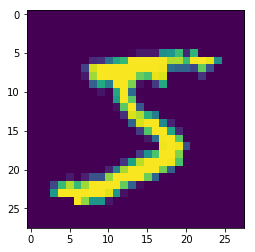

In [52]:
plt.imshow(train[0][0].numpy().reshape(28,28))

In [60]:
# ## CREATE DATASET!!

# import cv2
# curr_label = None


# for image,label in train:

#     num = len(os.listdir('.\\Dataset2_Aug\\train\\' +str(label)))+1

#     x = image.numpy().reshape(28,28)
#     frame_normed = 255 * (x - x.min()) / (x.max() - x.min())
#     frame_normed = np.array(frame_normed, np.int)
#     cv2.imwrite('.\\Dataset2_Aug\\train\\' +str(label) +'\\'+ str(num) +'_cre'+".jpg" ,frame_normed)
    
#     curr_label = label

In [32]:
# {x:list(train.train_labels).count(x) for x in range(10)}

C:\Users\saina\Anaconda3\envs\pytorchenv\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

## Data Transformations

In [34]:
from data_aug import Invert , CustomAug , GammaCorrect

data_transforms = transforms.Compose([
#     Invert(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32)),
    transforms.CenterCrop(28),
    GammaCorrect(),
    CustomAug(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])



data_transforms2 = transforms.Compose([
#     Invert(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32,32)),
    transforms.CenterCrop(28),
    GammaCorrect(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# # Train phase transformations
# train_transforms = transforms.Compose([
#     # Rotate image by 7 degrees
#     transforms.RandomRotation((-6.0, 6.0), fill=(1,)),

#     # convert the data to torch.FloatTensor with values within the range [0.0 ,1.0]
#     transforms.ToTensor(),

#     # normalize the data with mean and standard deviation
#     # these values were obtained from the data statistics above
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

# # Test phase transformations
# test_transforms = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,))
# ])

## Data

In [50]:
from torch.utils.data import DataLoader , Dataset

root = '.\\Dataset2_Aug\\'

train_data = datasets.ImageFolder(root+'train',transform =  data_transforms)
# train_loader = DataLoader(train_data,batch_size =32,shuffle=True)

test_data = datasets.ImageFolder(root+'test',transform =  data_transforms2)
# test_loader = DataLoader(test_data,batch_size =32,shuffle=False)

In [36]:
for img,lab in train_data:
    break

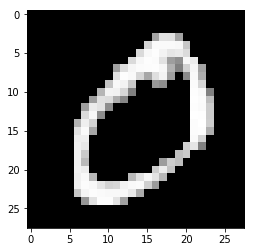

In [37]:
x = img.numpy().reshape(28,28)
img = x
plt.imshow(img,cmap = 'gray')

## DATA LOADERS

In [51]:
SEED = 1

cuda = torch.cuda.is_available()
print('CUDA Available?', cuda)

# For reproducibility of results
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? True


In [38]:
for imgs,lab in train_loader:
    break

In [39]:
lab[1]

tensor(0)

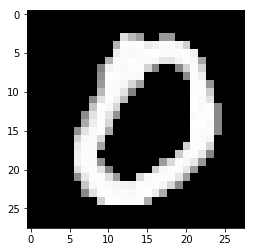

In [41]:
x = imgs[12].numpy().reshape(28,28)
img = x
plt.imshow(img,cmap = 'gray')

# Model Architecture

In [52]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        dropout_rate = 0.01

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_rate)
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 22x22x16 | Output: 20x20x16 | RF: 9x9

        self.pool = nn.MaxPool2d(2, 2)  # Input: 20x20x16 | Output: 10x10x16 | RF: 10x10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 10x10x16 | Output: 8x8x16 | RF: 14x14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )  # Input: 8x8x16 | Output: 6x6x16 | RF: 18x18

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_rate)
        )  # Input: 6x6x16 | Output: 6x6x10 | RF: 18x18

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 6x6x10 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Parameters
Let's see the model summary

In [53]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,168
             ReLU-10           [-1, 16, 22, 22]               0
      BatchNorm2d-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
           Conv2d-13           [-1, 16, 20, 20]           2,320
             ReLU-14           [-1

# Model Training and Evaluation

In [54]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero before starting backpropagation
        optimizer.zero_grad()

        # Predict output
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Perform backpropagation
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_accuracies.append(100 * correct / processed)
        pbar.set_description(desc=f'Loss={loss.item():0.2f} Batch_ID={batch_idx} Accuracy={train_accuracies[-1]:.2f}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / len(test_loader.dataset))

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracies[-1]:.2f}%)\n')

In [55]:
len(test_data)

470

In [56]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.15)
epochs = 15

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|                                                                                          | 0/988 [00:00<?, ?it/s]

Epoch 1:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.2395, Accuracy: 437/470 (92.98%)

Epoch 2:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.1314, Accuracy: 453/470 (96.38%)

Epoch 3:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.1341, Accuracy: 452/470 (96.17%)

Epoch 4:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0834, Accuracy: 456/470 (97.02%)

Epoch 5:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0927, Accuracy: 455/470 (96.81%)

Epoch 6:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0651, Accuracy: 457/470 (97.23%)

Epoch 7:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0705, Accuracy: 456/470 (97.02%)

Epoch 8:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Accuracy: 459/470 (97.66%)

Epoch 9:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Accuracy: 458/470 (97.45%)

Epoch 10:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0713, Accuracy: 457/470 (97.23%)

Epoch 11:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 459/470 (97.66%)

Epoch 12:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0687, Accuracy: 457/470 (97.23%)

Epoch 13:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0670, Accuracy: 458/470 (97.45%)

Epoch 14:


  0%|                                                                                          | 0/988 [00:00<?, ?it/s]


Test set: Average loss: 0.0641, Accuracy: 457/470 (97.23%)

Epoch 15:


Loss=0.15 Batch_ID=987 Accuracy=98.73: 100%|█████████████████████████████████████████| 988/988 [00:25<00:00, 38.90it/s]



Test set: Average loss: 0.0609, Accuracy: 460/470 (97.87%)



In [57]:
torch.save(model.state_dict() , 'C://Users//saina//Documents//Pytorch//model//mnist_trained_aug.pt') 

In [58]:
for param in model.parameters():
    print(param[0])
    break

tensor([[[ 0.3470, -0.2385,  0.3661],
         [ 0.1685, -0.2591, -0.1033],
         [ 0.2173, -0.1575, -0.1174]]], device='cuda:0',
       grad_fn=<SelectBackward>)


## Result Analysis

Text(0.5, 1.0, 'Test Accuracy')

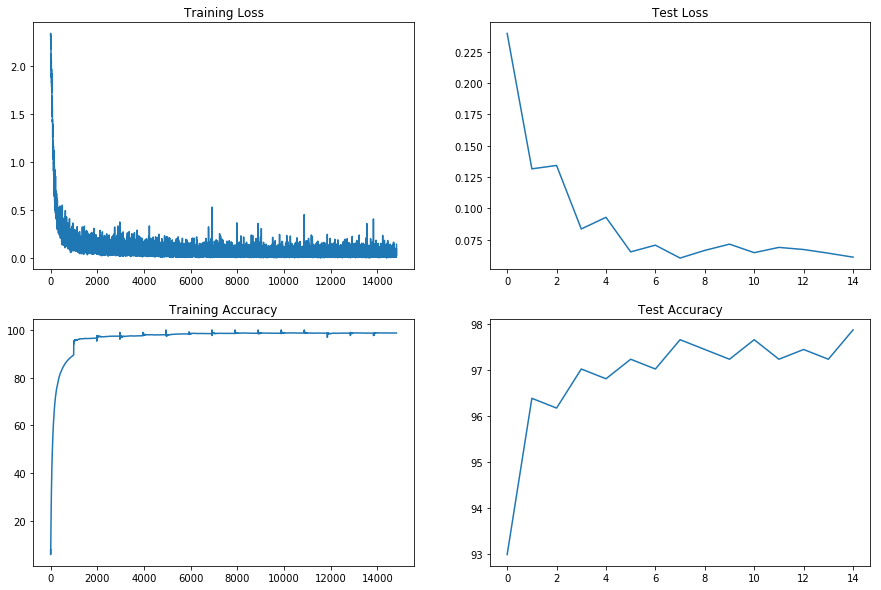

In [59]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")